In [1]:
from helper import *
import helper

# Set random seed for reproducibility
seed_value = 5
set_random_seed(seed_value)

from sklearn.metrics import jaccard_score


from torchvision import transforms

# Applying the transform to an image (example)
from PIL import Image

torch.cuda.is_available()

True

In [2]:
data_dir = '/home/vs/Developer/obia-dl-ms-kerner-lab/neon-tree/neon-tree-rgb-label'

In [3]:
batch_size = 16 # set to 1 for test_loader
num_workers = 8 # matters if gpu idle, if gpu running
num_epochs = 10  # Set the number of epochs

In [4]:
# Define the transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToTensor(), 
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet's mean and std
])

label_transforms = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),  # Use nearest neighbor interpolation to keep label values intact
])

class nzCattleDataset(Dataset):
    """Custom Dataset for loading New Zealand Cattle data."""
    def __init__(self, data_dir, split, image_transform=None, label_transform=None):
        self.data_dir = data_dir
        self.image_transform = image_transform
        self.label_transform = label_transform

        with open(os.path.join(data_dir, 'default_partition.json')) as f:
            partition = json.load(f)[split]

        self.image_filenames = [f'{name}_image.png' for name in partition]
        self.label_filenames = [f'{name}_label.png' for name in partition]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.image_filenames[index])
        label_path = os.path.join(self.data_dir, self.label_filenames[index])

        image = Image.open(image_path)  # Ensure RGB format
        label = Image.open(label_path)

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        
        # Convert to Tensors
        # image_t = torch.from_numpy(np.array(image)).permute(2, 0, 1).float()  # Assuming channels-first
        label_t = torch.from_numpy(np.array(label)).long().unsqueeze(0)  # Assuming channels-last
        
        return image, label_t

train_dataset = nzCattleDataset(data_dir, split='train', image_transform=image_transforms, label_transform=label_transforms)
val_dataset = nzCattleDataset(data_dir, split='valid', image_transform=image_transforms, label_transform=label_transforms)
test_dataset = nzCattleDataset(data_dir, split='test', image_transform=image_transforms, label_transform=label_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)



Images Batch shape: torch.Size([16, 3, 512, 512]), Labels Batch shape: torch.Size([16, 1, 512, 512])
Labels unique values: tensor([0, 1]), Labels min: 0, Labels max: 1
Image shape: torch.Size([3, 512, 512]), Label shape: torch.Size([1, 512, 512]), Image type: torch.float32, Label type: torch.int64
Label unique values: tensor([0, 1]), Label min: 0, Label max: 1


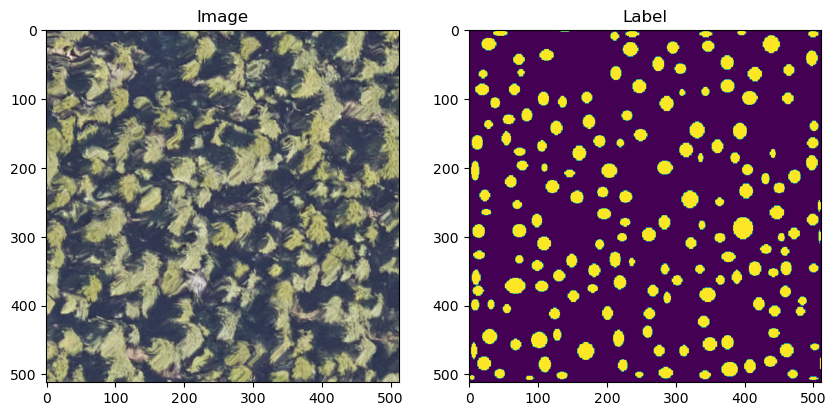

In [5]:
# Get a sample batch from the dataloader
for images, labels in train_loader:
    print(f"Images Batch shape: {images.shape}, Labels Batch shape: {labels.shape}")
    print(f"Labels unique values: {torch.unique(labels)}, Labels min: {torch.min(labels)}, Labels max: {torch.max(labels)}")

    image = images[0]
    label = labels[0]

    print(f"Image shape: {image.shape}, Label shape: {label.shape}, Image type: {image.dtype}, Label type: {label.dtype}")   
    print(f"Label unique values: {torch.unique(label)}, Label min: {torch.min(label)}, Label max: {torch.max(label)}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.permute(1, 2, 0))
    ax1.set_title('Image')
    ax2.imshow(label.permute(1, 2, 0))
    ax2.set_title('Label')
    plt.show()

    break  # Exit the loop after plotting one sample

In [6]:
len(train_loader), len(val_loader), len(test_loader)

(17, 6, 6)

In [7]:
# Count the number of images and labels in the dataset
train_images, train_labels = count_images_and_labels(train_loader)
val_images, val_labels = count_images_and_labels(val_loader)
test_images, test_labels = count_images_and_labels(test_loader)

print(f"Train Dataloader: {train_images} images, {train_labels} labels")
print(f"Val Dataloader: {val_images} images, {val_labels} labels")
print(f"Test Dataloader: {test_images} images, {test_labels} labels")


Train Dataloader: 270 images, 270 labels
Val Dataloader: 94 images, 94 labels
Test Dataloader: 93 images, 93 labels


In [8]:
# class SegmentationModel(nn.Module):
#     def __init__(self, pretrained_path=None, fine_tune_start_layer=3):
#         super(SegmentationModel, self).__init__()
#         # Load a pretrained ResNet-50 without pretrained weights
#         backbone = models.resnet50(pretrained=False)

#         if pretrained_path:
#             state_dict = torch.load(pretrained_path, map_location='cpu')
#             # If the state dict has the 'state_dict' key (common in training scripts), use the inner dict
#             if 'state_dict' in state_dict:
#                 state_dict = {k.replace('module.', ''): v for k, v in state_dict['state_dict'].items()}
#             backbone.load_state_dict(state_dict, strict=False)

#         # Freeze the early layers
#         for param in list(backbone.parameters())[:fine_tune_start_layer]:
#             param.requires_grad = False

#         # Remove the fully connected layer and the average pooling layer
#         self.encoder = nn.Sequential(*list(backbone.children())[:-2])

#         # Increase the output resolution by adding additional upsampling layers
#         # Redesigning the decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),  # size becomes 2x of input (e.g., from 16x16 to 32x32)
#             nn.ReLU(),
#             nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),   # size becomes 2x of input (e.g., from 32x32 to 64x64)
#             nn.ReLU(),
#             nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),   # size becomes 2x of input (e.g., from 64x64 to 128x128)
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),   # size becomes 2x of input (e.g., from 128x128 to 256x256)
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),    # size becomes 2x of input (e.g., from 256x256 to 512x512)
#             nn.ReLU(),
#             nn.Conv2d(64, 1, kernel_size=1),  # 1x1 convolution to adjust channel dimension to 1
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [9]:
class SegmentationModel(nn.Module):
    def __init__(self, pretrained_path=None):
        super(SegmentationModel, self).__init__()
        # Load a pretrained ResNet-50 without pretrained weights
        backbone = models.resnet50(pretrained=False)

        if pretrained_path:
            state_dict = torch.load(pretrained_path, map_location='cpu')
            # If the state dict has the 'state_dict' key (common in training scripts), use the inner dict
            if 'state_dict' in state_dict:
                state_dict = {k.replace('module.', ''): v for k, v in state_dict['state_dict'].items()}
            backbone.load_state_dict(state_dict, strict=False)

        # Remove the fully connected layer and the average pooling layer
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])

        # Increase the output resolution by adding additional upsampling layers
        # Redesigning the decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),  # size becomes 2x of input (e.g., from 16x16 to 32x32)
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),   # size becomes 2x of input (e.g., from 32x32 to 64x64)
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),   # size becomes 2x of input (e.g., from 64x64 to 128x128)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),   # size becomes 2x of input (e.g., from 128x128 to 256x256)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),    # size becomes 2x of input (e.g., from 256x256 to 512x512)
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),  # 1x1 convolution to adjust channel dimension to 1
        )

        # # Freeze all layers except the last l in the decoder
        # l = 6
        # all_layers = list(self.encoder.parameters()) + list(self.decoder.parameters())
        # total_layers = len(all_layers)
        # for i, param in enumerate(all_layers):
        #     if i < total_layers - l:
        #         param.requires_grad = False  # Freeze all but the last l layers

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
pretrained_weights_path = './detconb_resnet50_imagenet300_torchvision.pth.tar'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = SegmentationModel(pretrained_path=pretrained_weights_path)
model.to(device)

/home/vs/miniconda3/envs/obia-dl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vs/miniconda3/envs/obia-dl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SegmentationModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [11]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        inputs = torch.sigmoid(inputs)  # Apply sigmoid to squash outputs to a [0,1] range
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_coeff


In [12]:
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, ce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.BCEWithLogitsLoss()  # This loss combines a Sigmoid layer and the BCELoss in one single class.
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight

    def forward(self, inputs, targets):
        dice_loss = self.dice_loss(inputs, targets)
        ce_loss = self.ce_loss(inputs, targets)
        return self.dice_weight * dice_loss + self.ce_weight * ce_loss


In [13]:
def iou_score(outputs, masks):
    # Apply sigmoid to convert logits to probabilities
    probs = torch.sigmoid(outputs)
    
    # Convert probabilities to binary predictions
    preds = (probs > 0.5).float()
    
    # Calculate Intersection (True Positives)
    intersection = (preds * masks).sum(dim=[2, 3])
    
    # Calculate Union: Predicted Positives + Actual Positives - Intersection
    union = ((preds + masks) > 0).float().sum(dim=[2, 3])
    
    # Initialize IoU tensor with zeros
    iou = torch.zeros_like(intersection)
    
    # Only calculate IoU for non-zero unions, to avoid division by zero
    nonzero_union = union > 0
    iou[nonzero_union] = intersection[nonzero_union] / union[nonzero_union]
    
    return iou


In [14]:
def precision_score(preds, labels):
    preds = torch.sigmoid(preds) > 0.5  # Converting logits to binary predictions (0 or 1)
    true_positive = torch.sum(preds * labels).float()
    predicted_positive = torch.sum(preds).float()
    precision = true_positive / (predicted_positive + 1e-8)  # Adding a small constant to avoid division by zero
    return precision


In [15]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
# criterion = CombinedLoss(dice_weight=0.7, ce_weight=0.3)  # More weight to Dice loss
criterion = DiceLoss()
# criterion = nn.BCEWithLogitsLoss()

In [16]:
dummy_input = torch.randn(1, 3, 500, 500).to(device)  # Simulate a single input image
output = model(dummy_input)
print(output.shape) 

torch.Size([1, 1, 512, 512])


In [17]:

# # Example training loop
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, masks in train_loader:
#         images = images.to(device)
#         masks = masks.to(device).float()
#         print(image.dtype, masks.dtype)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, masks)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

In [18]:
train_losses = []
val_losses = []
train_iou_scores = []
val_iou_scores = []
train_precision_scores = []
val_precision_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_precision = 0.0
    
    train_loop = tqdm(train_loader, leave=True, position=0)
    for images, labels in train_loop:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_iou = iou_score(outputs, labels).mean()
        batch_precision = precision_score(outputs, labels)
        running_iou += batch_iou.item()
        running_precision += batch_precision.item()
        
        train_loop.set_description(f'Epoch {epoch+1}/{num_epochs}')
        train_loop.set_postfix(loss=loss.item(), IoU=batch_iou.item(), Precision=batch_precision.item())
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    epoch_iou = running_iou / len(train_loader)
    train_iou_scores.append(epoch_iou)
    epoch_precision = running_precision / len(train_loader)
    train_precision_scores.append(epoch_precision)

    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_precision = 0.0
    val_loop = tqdm(val_loader, leave=True, position=0)
    with torch.no_grad():
        for images, labels in val_loop:
            images = images.to(device).float()
            labels = labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            batch_iou_val = iou_score(outputs, labels).mean()
            batch_precision_val = precision_score(outputs, labels)
            val_iou += batch_iou_val.item()
            val_precision += batch_precision_val.item()
            
            val_loop.set_description('Validation')  
            val_loop.set_postfix(loss=loss.item(), IoU=batch_iou.item(), Precision=batch_precision_val.item())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_iou /= len(val_loader)
    val_iou_scores.append(val_iou)
    val_precision /= len(val_loader)
    val_precision_scores.append(val_precision)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train IoU: {epoch_iou:.4f}, Val IoU: {val_iou:.4f}, Train Precision: {epoch_precision:.4f}, Val Precision: {val_precision:.4f}')


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.49it/s, IoU=0.202, Precision=0.253, loss=0.816]


Epoch 1/10, Train Loss: 0.7215, Val Loss: 0.7823, Train IoU: 0.1519, Val IoU: 0.1297, Train Precision: 0.1793, Val Precision: 0.2355


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.07it/s, IoU=0.291, Precision=0.324, loss=0.806]


Epoch 2/10, Train Loss: 0.6907, Val Loss: 0.7779, Train IoU: 0.2289, Val IoU: 0.1251, Train Precision: 0.2640, Val Precision: 0.3430


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s, IoU=0.331, Precision=0.304, loss=0.593]


Epoch 3/10, Train Loss: 0.6341, Val Loss: 0.6191, Train IoU: 0.2817, Val IoU: 0.1948, Train Precision: 0.3457, Val Precision: 0.2894


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s, IoU=0.288, Precision=0.437, loss=0.713]


Epoch 4/10, Train Loss: 0.4637, Val Loss: 0.7229, Train IoU: 0.3175, Val IoU: 0.1148, Train Precision: 0.4671, Val Precision: 0.4194


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s, IoU=0.348, Precision=0.506, loss=0.531]


Epoch 5/10, Train Loss: 0.4030, Val Loss: 0.5563, Train IoU: 0.3692, Val IoU: 0.2136, Train Precision: 0.5448, Val Precision: 0.5177


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s, IoU=0.396, Precision=0.5, loss=0.515]  


Epoch 6/10, Train Loss: 0.3639, Val Loss: 0.5346, Train IoU: 0.4050, Val IoU: 0.2352, Train Precision: 0.5975, Val Precision: 0.5137


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s, IoU=0.378, Precision=0.539, loss=0.548]


Epoch 7/10, Train Loss: 0.3272, Val Loss: 0.5576, Train IoU: 0.4428, Val IoU: 0.2221, Train Precision: 0.6481, Val Precision: 0.5816


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s, IoU=0.51, Precision=0.571, loss=0.537]


Epoch 8/10, Train Loss: 0.2916, Val Loss: 0.5557, Train IoU: 0.4857, Val IoU: 0.2020, Train Precision: 0.6924, Val Precision: 0.5731


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s, IoU=0.448, Precision=0.547, loss=0.536]


Epoch 9/10, Train Loss: 0.2713, Val Loss: 0.5569, Train IoU: 0.5050, Val IoU: 0.2136, Train Precision: 0.7148, Val Precision: 0.5764


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.13it/s, IoU=0.506, Precision=0.601, loss=0.563]

Epoch 10/10, Train Loss: 0.2471, Val Loss: 0.5825, Train IoU: 0.5365, Val IoU: 0.1942, Train Precision: 0.7544, Val Precision: 0.6195


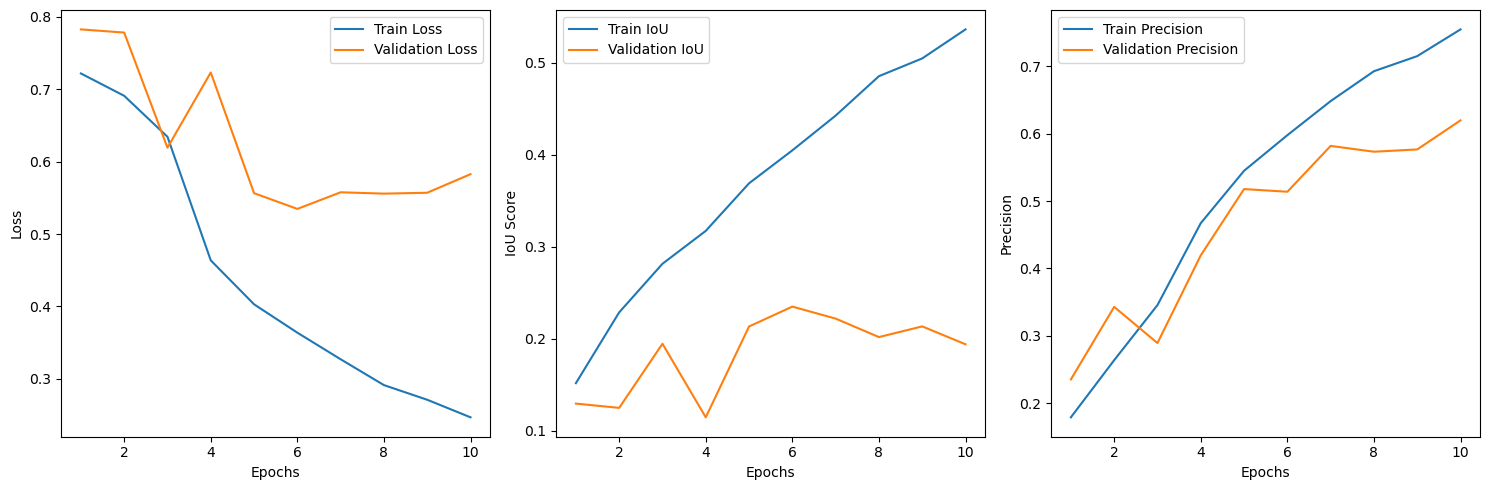

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_iou_scores, label='Train IoU')
plt.plot(range(1, num_epochs+1), val_iou_scores, label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_precision_scores, label='Train Precision')
plt.plot(range(1, num_epochs+1), val_precision_scores, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
# Testing the final trained model
model.eval()
test_loss = 0.0
test_iou = 0.0
test_precision = 0.0
count = 0

# Wrap test_loader with tqdm for a progress bar
test_loop = tqdm(test_loader, leave=True, position=0)
with torch.no_grad():
    for images, masks in test_loop:
        images = images.to(device).float()
        masks = masks.to(device).float()
        outputs = model(images)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        batch_iou = iou_score(outputs, masks).mean()
        test_iou += batch_iou.item()

        batch_precision = precision_score(outputs, masks)
        test_precision += batch_precision.item()

        # Optional: Update tqdm description with loss, IoU, and precision
        test_loop.set_description('Test Evaluation')
        test_loop.set_postfix(loss=loss.item(), IoU=batch_iou.item(), Precision=batch_precision.item())

        
# Calculate the average loss, IoU, and precision over all test data
test_loss /= len(test_loader)
test_iou /= len(test_loader)
test_precision /= len(test_loader)

# Print the final results including precision
print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Precision: {test_precision:.4f}')


Test Evaluation: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s, IoU=0.127, Precision=0.604, loss=0.606]

Test Loss: 0.5791, Test IoU: 0.1700, Test Precision: 0.6117


In [2]:
import numpy as np
from scipy.stats import sem, t, ttest_ind

# Define model data
model_1_precision = np.array([0.52, 0.57, 0.59, 0.57, 0.58])
model_1_iou = np.array([0.17, 0.19, 0.18, 0.16, 0.14])

model_2_precision = np.array([0.56, 0.62, 0.65, 0.60, 0.61])
model_2_iou = np.array([0.19, 0.16, 0.13, 0.16, 0.17])

# Function to calculate mean and 95% confidence interval
def mean_and_ci(data):
    mean = np.mean(data)
    ci = sem(data) * t.ppf((1 + 0.95) / 2, len(data) - 1)
    return round(mean, 2), round(mean - ci, 2), round(mean + ci, 2)

# Calculate mean and confidence intervals for both models
mean1_p, ci1_p_low, ci1_p_high = mean_and_ci(model_1_precision)
mean1_iou, ci1_iou_low, ci1_iou_high = mean_and_ci(model_1_iou)
mean2_p, ci2_p_low, ci2_p_high = mean_and_ci(model_2_precision)
mean2_iou, ci2_iou_low, ci2_iou_high = mean_and_ci(model_2_iou)

# Perform t-tests
t_test_precision = ttest_ind(model_1_precision, model_2_precision)
t_test_iou = ttest_ind(model_1_iou, model_2_iou)

# Output results
print("Model 1 Precision Mean and CI:", mean1_p, (ci1_p_low, ci1_p_high))
print("Model 1 IoU Mean and CI:", mean1_iou, (ci1_iou_low, ci1_iou_high))
print("Model 2 Precision Mean and CI:", mean2_p, (ci2_p_low, ci2_p_high))
print("Model 2 IoU Mean and CI:", mean2_iou, (ci2_iou_low, ci2_iou_high))
print("T-test Precision (statistic, p-value):", round(t_test_precision.statistic, 2), round(t_test_precision.pvalue, 4))
print("T-test IoU (statistic, p-value):", round(t_test_iou.statistic, 2), round(t_test_iou.pvalue, 4))


Model 1 Precision Mean and CI: 0.57 (0.53, 0.6)
Model 1 IoU Mean and CI: 0.17 (0.14, 0.19)
Model 2 Precision Mean and CI: 0.61 (0.57, 0.65)
Model 2 IoU Mean and CI: 0.16 (0.14, 0.19)
T-test Precision (statistic, p-value): -2.21 0.0578
T-test IoU (statistic, p-value): 0.46 0.6558


To determine if there is a statistically significant difference between the two models based on the t-test results you provided, you can look at the p-values:

1. **T-test Precision (p-value: 0.0578)**: This p-value is greater than the commonly used significance level of 0.05. This suggests that the differences in precision between the two models are not statistically significant at the 5% level. However, the result is quite close to the threshold, indicating a marginal case that might be considered significant in a less stringent analysis or could prompt further investigation.

2. **T-test IoU (p-value: 0.6558)**: This p-value is much higher than the typical significance level of 0.05. It indicates that there is no statistically significant difference in the IoU scores between the two models.

In summary:
- There is **no statistically significant difference** in the IoU scores between the two models.
- The difference in precision is also not statistically significant at the traditional 0.05 level, though the result is on the cusp and could warrant a closer look or additional studies with more data or alternative methods of analysis depending on the context or stakes involved.